# imports & catalogues

In [219]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy.table import join
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import astropy.cosmology.units as cu
from astropy.coordinates import SkyCoord
from scipy.optimize import linear_sum_assignment


SAMI_Target_catalogues = ("InputCatGAMADR3.fits", "InputCatClustersDR3.fits", "InputCatFiller.fits")
SAMI_regions = {0: "GAMA", 1: "Clusters", 2: "Filler"}

Source_dir ="C:\\Users\\mspan\\OneDrive - The University of Sydney (Students)\\Honours\\Honours Project\\"
catalogue_filepath = Source_dir + "Catalogues\\"
SAMI_regions = ("Cluster", "Filler", "GAMA")
SAMI_spectra_catalogue = "EmissionLine1compDR3.fits"
SAMI_SFR_catalogue = "AR2022_SAMI_DR3_Mstar_SFR_GSWL_rescaled.fits"
SAMI_AGN_summary_catalogue = "Crossmatched\\SAMI_AGN_matches.fits"
SAMI_cubeobs_catalogue = "CubeObs.fits"

def refresh_module():
    import importlib
    import all_fctns
    importlib.reload(all_fctns)


with fits.open(catalogue_filepath + "\\Crossmatched\\SAMI_AGN_matches.fits") as SAMI_AGN_matches_hdul:
    Summary_table_hdu = Table(SAMI_AGN_matches_hdul[1].data)

with fits.open(catalogue_filepath + SAMI_SFR_catalogue) as SAMI_SFR_hdul:
    SAMI_SFR_table_hdu = Table(SAMI_SFR_hdul[1].data)

with fits.open(catalogue_filepath + SAMI_spectra_catalogue) as SAMI_spectra_hdul:
    SAMI_spectra_table_hdu = Table(SAMI_spectra_hdul[1].data)

with fits.open(catalogue_filepath + SAMI_cubeobs_catalogue) as SAMI_CubeObs_hdul:
    SAMI_CubeObs_table_hdu =  Table(SAMI_CubeObs_hdul[1].data)

AGN_mask = np.isin(Summary_table_hdu['CATEGORY_BPT_AGN'], [6, 7, 8, 9, 10])
HII_Composite_mask = np.isin(Summary_table_hdu['CATEGORY_BPT_AGN'], [0, 1, 2])
possible_AGN_mask = np.isin(Summary_table_hdu['CATEGORY_BPT_AGN'], [3, 4, 5])
inconclusive_mask = np.isin(Summary_table_hdu['CATEGORY_BPT_AGN'], [-1, 999999])
na_mask = Summary_table_hdu['CATEGORY_BPT_AGN'] == 999999

AGN_CATIDs = Summary_table_hdu['CATID'][AGN_mask]
HII_Composite_CATIDs = Summary_table_hdu['CATID'][HII_Composite_mask]

AGN_colour = 'red'
HII_Composite_colour = 'blue'
possible_AGN_colour = 'orange'
inconclusive_colour = 'grey'

BPT_classification_dict = {'AGN': (AGN_mask, AGN_colour),
                            'Possible AGN': (possible_AGN_mask, possible_AGN_colour),
                           'HII_Composite': (HII_Composite_mask, HII_Composite_colour),
                           'Inconclusive': (inconclusive_mask, inconclusive_colour)}



# M_STAR investigation

## M_STAR v SFR plot

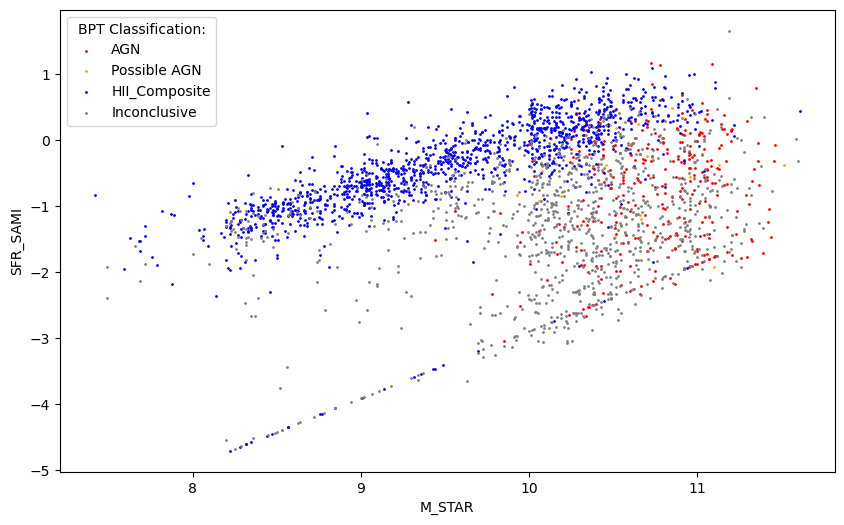

In [220]:
M_STAR_array = Summary_table_hdu['M_STAR']
SFR_SAMI_array = Summary_table_hdu['SFR_SAMI']

plt.figure(figsize=(10, 6))

for category, (mask, colour) in BPT_classification_dict.items():
    if np.any(mask):
        plt.scatter(M_STAR_array[mask], SFR_SAMI_array[mask], s=1, label=category, color=colour)

plt.xlabel('M_STAR')
plt.ylabel('SFR_SAMI')

plt.legend(title='BPT Classification:')

## Mass Distributions

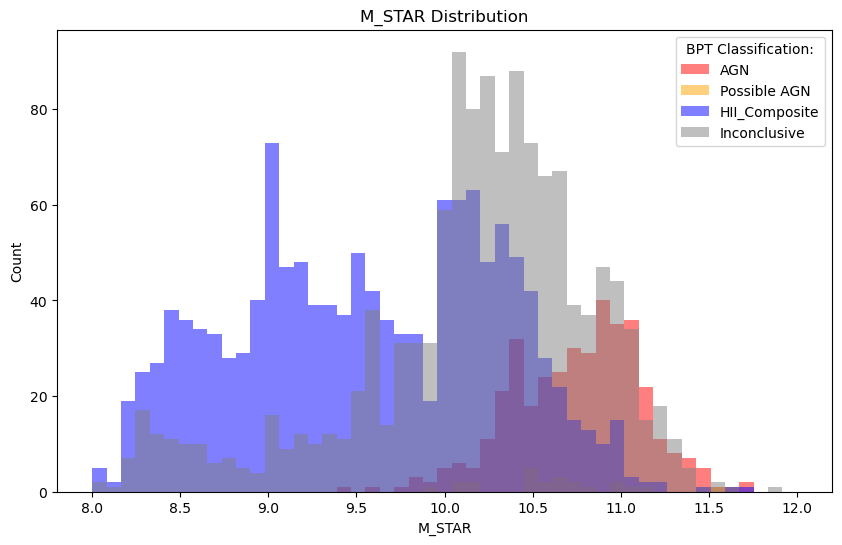

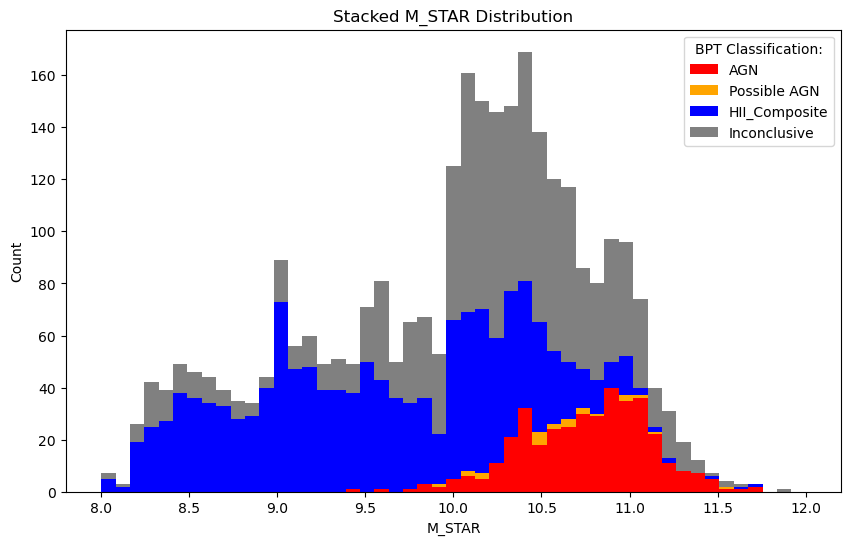

In [221]:
bins = np.linspace(8, 12, 50)

plt.figure(figsize=(10, 6))

for category, (mask, colour) in BPT_classification_dict.items():
    if np.any(mask):
        plt.hist(M_STAR_array[mask], bins=bins, label=category, alpha=0.5, color=colour)

plt.xlabel('M_STAR')
plt.ylabel('Count')
plt.title('M_STAR Distribution')
plt.legend(title='BPT Classification:')

plt.show()


plt.figure(figsize=(10, 6))
M_STAR_ls = []
for category, (mask, colour) in BPT_classification_dict.items():
    M_STAR_ls.append(M_STAR_array[mask])
plt.hist(M_STAR_ls, bins=bins, label=BPT_classification_dict.keys(), stacked=True, color=[BPT_classification_dict[cat][1] for cat in BPT_classification_dict.keys()])
plt.xlabel('M_STAR')
plt.ylabel('Count')
plt.title('Stacked M_STAR Distribution')
plt.legend(title='BPT Classification:')

plt.show()

## AGN Mass percentage distribution

### line-plot

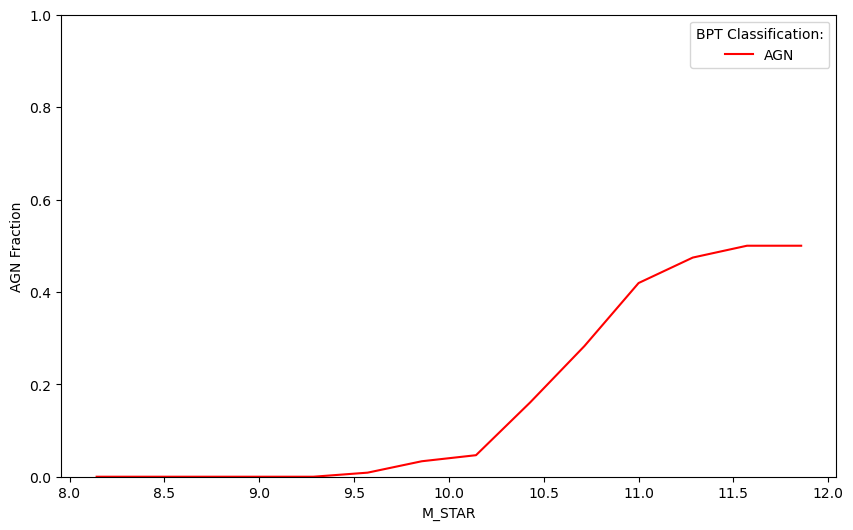

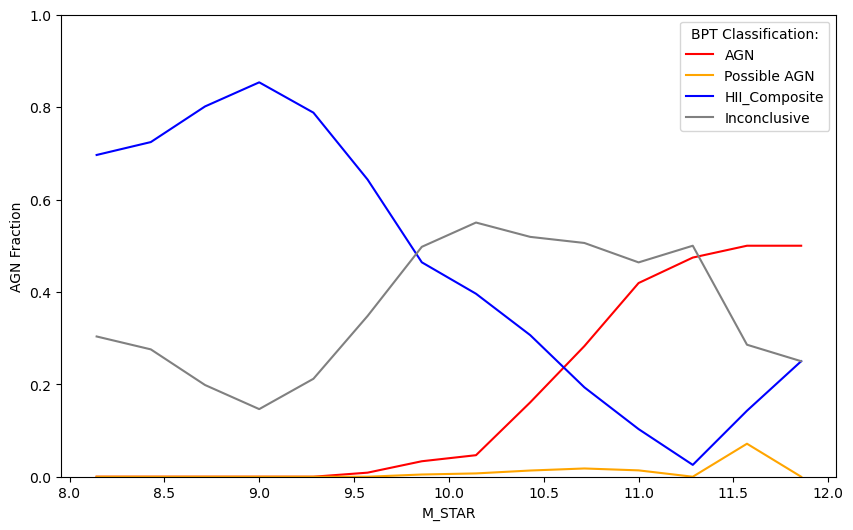

In [222]:
nbins = 15
bins = np.linspace(8, 12, nbins)
total_counts, _ = np.histogram(M_STAR_array, bins=bins)

plt.figure(figsize=(10, 6))
AGN_counts, _ = np.histogram(M_STAR_array[AGN_mask], bins=bins)
plt.plot(bins[:-1]+np.diff(bins)/2, AGN_counts / total_counts, label='AGN', color=AGN_colour, linestyle='-')

plt.xlabel('M_STAR')
plt.ylabel('AGN Fraction')
plt.ylim((0,1))
plt.legend(title='BPT Classification:')
plt.show()



plt.figure(figsize=(10, 6))

for category, (mask, colour) in BPT_classification_dict.items():
    category_counts, _ = np.histogram(M_STAR_array[mask], bins=bins)
    plt.plot(bins[:-1]+np.diff(bins)/2, category_counts / total_counts, label=category, color=colour, linestyle='-')

plt.xlabel('M_STAR')
plt.ylabel('AGN Fraction')
plt.ylim((0,1))
plt.legend(title='BPT Classification:')
plt.show()

### bar-plot

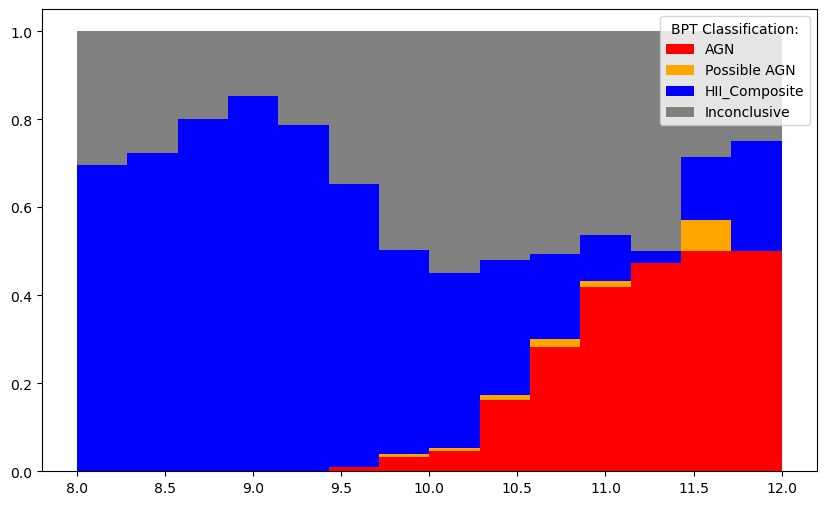

In [223]:
nbins = 15
bins = np.linspace(8, 12, nbins)
binwidth = np.diff(bins)
total_counts, _ = np.histogram(M_STAR_array, bins=bins)

plt.figure(figsize=(10, 6))
other_counts = np.zeros_like(total_counts)
for category, (mask, colour) in BPT_classification_dict.items():
    category_counts, _ = np.histogram(M_STAR_array[mask], bins=bins)
    plt.bar(bins[:-1]+np.diff(bins)/2, category_counts / total_counts, width=np.diff(bins), label=category, color=colour, bottom=other_counts)
    other_counts = other_counts + category_counts / total_counts
# normalised_AGN_counts = AGN_counts / total_counts
# normlised_other_counts = (total_counts - AGN_counts) / total_counts
# plt.bar(bins[:-1], normalised_AGN_counts, width=np.diff(bins), label='AGN', color=AGN_colour)
# plt.bar(bins[:-1], normlised_other_counts, width=np.diff(bins),  bottom=normalised_AGN_counts, label='Other', color=HII_Composite_colour)

plt.legend(title='BPT Classification:')